Files already downloaded and verified
Epoch [0/50] Batch 0/782                   Loss Critic: -0.0175, Loss Generator: 0.0205
Epoch [0/50] Batch 100/782                   Loss Critic: -1.3613, Loss Generator: 0.6917
Epoch [0/50] Batch 200/782                   Loss Critic: -1.5382, Loss Generator: 0.7801
Epoch [0/50] Batch 300/782                   Loss Critic: -1.5461, Loss Generator: 0.7833
Epoch [0/50] Batch 400/782                   Loss Critic: -1.5226, Loss Generator: 0.7781
Epoch [0/50] Batch 500/782                   Loss Critic: -1.4909, Loss Generator: 0.7253
Epoch [0/50] Batch 600/782                   Loss Critic: -1.4978, Loss Generator: 0.7613
Epoch [0/50] Batch 700/782                   Loss Critic: -1.4279, Loss Generator: 0.7626
Epoch [1/50] Batch 0/782                   Loss Critic: -1.4280, Loss Generator: 0.7333
Epoch [1/50] Batch 100/782                   Loss Critic: -1.3606, Loss Generator: 0.7448
Epoch [1/50] Batch 200/782                   Loss Critic: -1.3246,

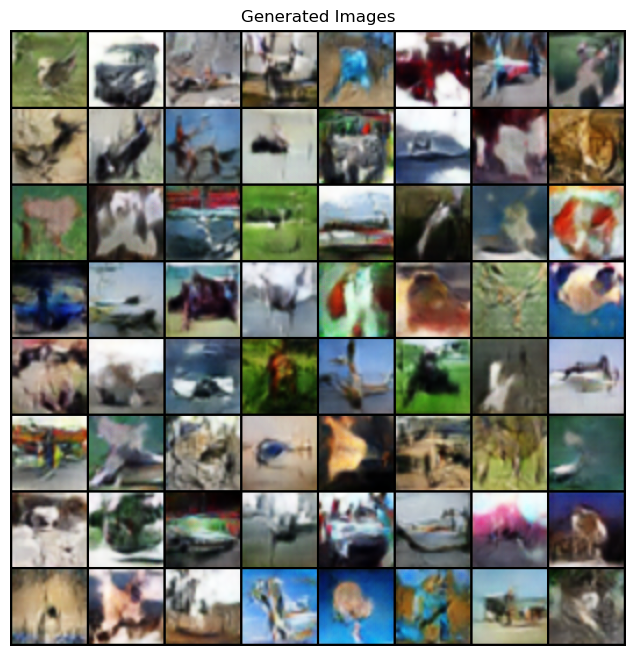

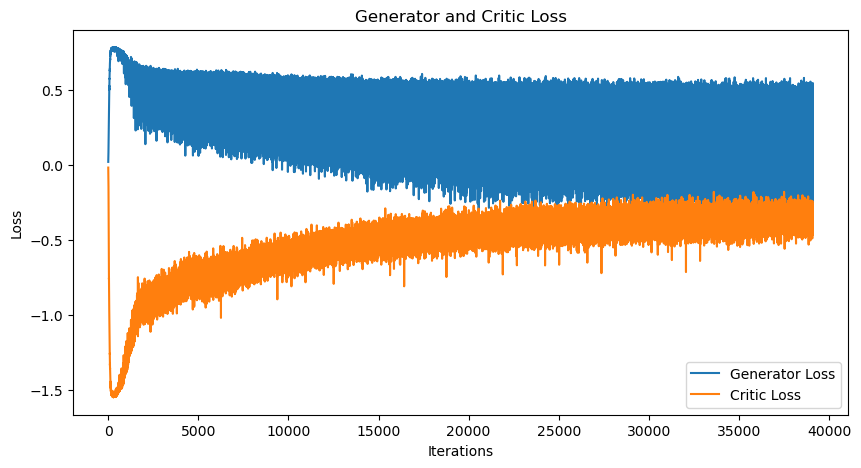

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
from torchvision.models import inception_v3
import numpy as np
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 64
lr = 5e-5
z_dim = 128
image_size = 64
channels_img = 3
features_gen = 64
features_critic = 64
n_critic = 5  # Number of critic updates per generator update
weight_clip = 0.01
epochs = 50

# Dataset and DataLoader
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

dataset = datasets.CIFAR10(root="./cifar10", download=True, transform=transform)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Generator
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            self._block(z_dim, features_g * 16, 4, 1, 0),
            self._block(features_g * 16, features_g * 8, 4, 2, 1),
            self._block(features_g * 8, features_g * 4, 4, 2, 1),
            self._block(features_g * 4, features_g * 2, 4, 2, 1),
            nn.ConvTranspose2d(features_g * 2, channels_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.gen(x)

# Critic (Discriminator)
class Critic(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Critic, self).__init__()
        self.critic = nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.critic(x)

# Initialize Generator and Critic
gen = Generator(z_dim, channels_img, features_gen).to(device)
critic = Critic(channels_img, features_critic).to(device)

# Optimizers
opt_gen = optim.RMSprop(gen.parameters(), lr=lr)
opt_critic = optim.RMSprop(critic.parameters(), lr=lr)

# Initialize weights
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

initialize_weights(gen)
initialize_weights(critic)

# Training Loop
fixed_noise = torch.randn(64, z_dim, 1, 1).to(device)
gen_losses, critic_losses = [], []

for epoch in range(epochs):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.to(device)
        cur_batch_size = real.size(0)

        # Train Critic
        for _ in range(n_critic):
            noise = torch.randn(cur_batch_size, z_dim, 1, 1).to(device)
            fake = gen(noise)
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))

            critic.zero_grad()
            loss_critic.backward()
            opt_critic.step()

            # Clip weights of Critic
            for p in critic.parameters():
                p.data.clamp_(-weight_clip, weight_clip)

        # Train Generator
        noise = torch.randn(cur_batch_size, z_dim, 1, 1).to(device)
        fake = gen(noise)
        gen_fake = critic(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)

        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Log losses
        gen_losses.append(loss_gen.item())
        critic_losses.append(loss_critic.item())

        # Print losses occasionally
        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch}/{epochs}] Batch {batch_idx}/{len(loader)} \
                  Loss Critic: {loss_critic:.4f}, Loss Generator: {loss_gen:.4f}")

# Visualization
gen.eval()
with torch.no_grad():
    fake_images = gen(fixed_noise).detach().cpu()
grid = vutils.make_grid(fake_images, normalize=True)
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.show()

# Plotting Losses
plt.figure(figsize=(10, 5))
plt.plot(gen_losses, label="Generator Loss")
plt.plot(critic_losses, label="Critic Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.title("Generator and Critic Loss")
plt.show()
